In [1]:
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt

# 1 Regresión Lineal Ordinaria (LSS)

Se comenzará el informe con la contrucción de un modelo para precedir el precio de una casa. Como datos de entrada se usará un *dataset* con las ventas en el condado de King County, EEUU entre Mayo de 2014 y Mayo de 2015. Para esto, se utilizará una regresión lineal ordinaria basada en LSS (Linear Least Squares)

## a) Ingreso de los datos

Los datos fueron obtenidos de Kaggle, y se encuentran en un archivo CSV. Las características o *features* id (número identificador), date (fecha) y zipcode (código postal) serán descartadas ya que de ante mano podemos suponer que no tienen relación con el precio de la casa.

In [2]:
df = pd.read_csv("kc_house_data.csv",sep = ",",header = 0)
df = df.drop(['id','date','zipcode'], axis=1)

## b) Análisis Descriptivo de los Datos

Primero es útil revisar el tamaño del dataset, junto con todo el resto de las características.

In [3]:
df.shape

(21613, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 18 columns):
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(13)
memory usage: 3.0 MB


In [5]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


## c) Transformación de las Variables

Los modelos de regresión lineal múltiple asumen ciertas cosas sobre el *dataset*:

* Las variables dependientes e independientes tienen una relación lineal
* Las variables siguen una distribución normal

Una función entregada por SciKit que nos puede ayudar para el segundo punto es StandardScaler, el cual hace lo que se llama Estandarización o Z-score normalization. Esto es, transformar las variables en sus z-scores a partir de:

$$x - \mu \over \sigma$$

Siendo $\mu$ el promedio de la población y $\sigma$ la desviación estándar de ésta. Esto va a permitir que los datos tengan una media o esperanza centrada en 0, y varianzas bajo el mismo orden de magnitud.

Para el caso de nuestra variable dependiente **precio**, se va a hacer además una transformación logarítmica. Ésta es una práctica común al trabajar con variables referidas a dinero, y tiene varias ventajas:

* Los precios en general tienen *skewness*, o sea, su histograma está desbalanceado, con la mayor parte de los datos acumulados en cierto rango de valores. Una transformacion logarítmica puede ayudar a balancear el histograma (mejorar la simetría), y hacer que su comportamiento sea similar a una distribución normal.
* Los cambios en el valor logarítmico de una variable pueden ser directamente interpretados como cambios porcentuales.
* El logaritmo puede convertir relaciones multiplicativas en relaciones aditivas (como en el caso anterior, donde los cambios son convertidos en adiciones), y por tanto, hace que patrones de crecimiento exponencial se conviertan en patrones lineales, los cuales funcionan mucho mejor con nuestro modelo.

http://www.jerrydallal.com/lhsp/logs.htm
https://www.r-statistics.com/2013/05/log-transformations-for-skewed-and-wide-distributions-from-practical-data-science-with-r/
https://people.duke.edu/~rnau/411log.htm


In [155]:
#Se guarda en la variable X todo el dataset
X = df
#Transformacion Logaritmica
y = np.log(df['price'])

# Se crea un vector "mascara" del largo del dataframe X, 
# y se elige un limite del 70% del dataset para ser usado como conjunto de entrenamiento
# El otro 30% sera un conjunto de prueba
mask = np.zeros(len(X))
limit = int(len(X)*0.7)
mask[:limit] = 1
istrain = (mask== 1)
Xtrain = X[istrain]
ytrain = y[istrain]
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]

# Se quita la columna de precio de X despues de la normalización, ya que esto estara en el vector Y
Xtrain = Xtrain.drop(['price'], axis=1)
Xtest = Xtest.drop(['price'], axis=1)

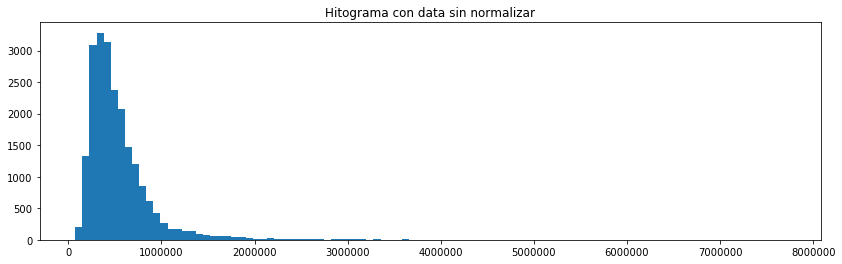

In [158]:
from matplotlib.pylab import hist, show
from pylab import rcParams

rcParams['figure.figsize'] = 14, 4

plt.title("Hitograma con data sin normalizar")
plt.hist(df['price'],bins=100)
plt.show()

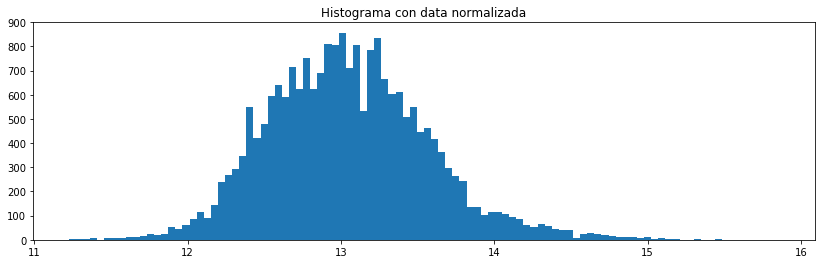

In [160]:
plt.title("Histograma con data normalizada")
plt.hist(np.log(df['price']), bins=100)
plt.show()

In [162]:
#df_scaled_train.describe()

Como vemos, logramos hacer que la media de las variables independientes sea muy cercana a cero, y que logre seguir distribuciones parecidas a una Gaussiana. Para el caso de la variable de precio, obtuvimos una escala distinta, pero también de tipo gaussiana.

## d) Contrucción del Modelo

A continuación se hará la regresión lineal. Recordando que la regresión lineal múltiple se puede ver como la resolución de un sistema de ecuaciones, donde cada elemento del conjunto de respuestas se puede ver como:

$$y_i = \beta_0 1 + \beta_1 x_{i1} + \cdots + \beta_q x_{iq} + \varepsilon_i$$

Sea $n$ el tamaño de la muestra (aquí, 21613) y $q$ el número de parámetros (aquí, 18). La ecuación de regresión lineal múltiple es:

$$ \large Y_{n \times 1} = X_{n \times q} \, \beta_{q \times 1} \, + \, \epsilon_{n \times 1}$$

$$
\begin{bmatrix} y_{1} \\ y_{2} \\ \vdots \\ y_{n} \end{bmatrix} = \begin{bmatrix} 1 & x_{11} & x_{12} & \dots & x_{1p} \\ 1 & x_{21} & x_{22} & \dots & x_{2p} \\ \vdots & \vdots & \vdots & & \vdots \\ 1 & x_{n1} & x_{n2} & \dots & x_{np} \end{bmatrix} \begin{bmatrix} \beta_0 \\ \beta_1 \\ \vdots \\ \beta_p \end{bmatrix} + \begin{bmatrix} \varepsilon_1\\ \varepsilon_2\\ \vdots\\ \varepsilon_n \end{bmatrix}
$$

Donde
* $Y$ es un vector de tamaño $n\times 1$, se le dice *vector de respuesta*
* $\epsilon$ es un vector de tamaño $n\times 1$, se le dice *vector de errores*
* $X$ es una matriz de tamaño $n\times q$, se le dice *matriz de diseño*
* $\beta$ es un vector de tamaño $q\times 1$, se le dice *vector de pendiente*

Ya que el elemento $\beta_0$ va multiplicado por uno, la matriz va a requerir una columna de unos.


http://dept.stat.lsa.umich.edu/~kshedden/Courses/Stat401/Notes/401-multreg.pdf

A la función LinearRegression le enviamos el parámetro **fit_intercept = False** debido a que los datos de precios ya están centrados

In [166]:
import sklearn.linear_model as lm
linreg = lm.LinearRegression(fit_intercept = False)
linreg.fit(df_scaled_train, ytrain)

print('Coeficientes: \n', linreg.coef_)
print(linreg.score(df_scaled_train, ytrain))

Coeficientes: 
 [ -1.00699259e-02   5.48449524e-02   6.53415939e+11   2.33409678e-02
   3.58327955e-02   3.32410136e-02   4.25700676e-02   4.60901157e-02
   1.85350908e-01  -5.81761385e+11  -3.24747439e+11  -1.05102539e-01
   1.53503418e-02   1.88049316e-01  -4.28009033e-03   8.43505859e-02
  -7.18688965e-03   1.30334287e+01]
0.767447905965


## e) Análisis de variables: Pesos y Z-score

Tenemos que los pesos asignados a cada variable serán los coeficientes $\hat{\beta}$ estimados en los puntos anteriores mediante el metodo de minimos cuadrados. Por otro lado tenemos que los Z-Score se obtienen siguien $\displaystyle z_i = \frac{\hat{\beta_i}}{\sigma_i\sqrt{v_i}}$, donde $v_i$ es el elemento $i-esimo$ de la diagonal de la matriz $(X^tX)^{-1}$

In [167]:
#Se carga el dataframe de los datos de entrenamiento en una arreglo para poder trabajar con los datos
def zscore(M):
    #X = np.array(df_scaled_train)
    #X = df_scaled_train.as_matrix()
    X = M
    #Se guarda la traspuesta de la matriz 
    Xt = np.transpose(X)
    #se computa el producto matricial entre la Xt y X 
    XtX = np.dot(Xt,X)
    # Se calcula la matriz de varianza-covarianza
    V = np.linalg.inv(XtX)
    # Se guarda la varianza (diagonal de la matriz)
    Vdiag = np.diag(V)
    #Se obtienen los coeficientes
    betas = linreg.coef_
    #se obtiene la desviacion estandar para cada variable
    sigma = df_scaled_train.std()
    #Se calculan los z-score
    z_score = betas/(sigma*np.sqrt(Vdiag))
    return np.array(z_score)

In [168]:
z_score = zscore(df_scaled_train.as_matrix())
d = {'1. Nombre_regresor' : df_scaled_train.columns,'2. Coeficientes' : pd.Series(linreg.coef_),'3. z-score': pd.Series(z_score)}
print(pd.DataFrame(d))

   1. Nombre_regresor  2. Coeficientes    3. z-score
0            bedrooms    -1.006993e-02 -9.603692e-01
1           bathrooms     5.484495e-02  3.706860e+00
2         sqft_living     6.534159e+11  1.090396e+07
3            sqft_lot     2.334097e-02  1.970461e+00
4              floors     3.583280e-02  3.147196e+00
5          waterfront     3.324101e-02  3.743769e+00
6                view     4.257007e-02  4.417291e+00
7           condition     4.609012e-02  5.189140e+00
8               grade     1.853509e-01  1.226781e+01
9          sqft_above    -5.817614e+11 -1.090396e+07
10      sqft_basement    -3.247474e+11 -1.090396e+07
11           yr_built    -1.051025e-01 -8.616066e+00
12       yr_renovated     1.535034e-02  1.760737e+00
13                lat     1.880493e-01  2.182469e+01
14               long    -4.280090e-03 -4.290158e-01
15      sqft_living15     8.435059e-02  5.985638e+00
16         sqft_lot15    -7.186890e-03 -5.996161e-01
17          intercept     1.303343e+01        

## f) K-fold cross-Validation

El sobreajuste es una complicacion que poseen la mayoria de algoritmos de machine learning, la cual conciste en ajustarse a caracteristicas muy especificas de los datos de entrenamiento provocando que el modelo pierda la capacidad de generalización. Una forma de lidiar con este problema es realizar una validacion cruzadada de los datos.

Para este item se usara el metodo de K-fold cross-validation con $k=5$ y $k=10$ respectivamente.


In [14]:
#Se normaliza la data de test
x_test = pd.DataFrame(scaler.transform(Xtest),columns=Xtest.columns)
#Se agrega la columna "intercept"
x_test.insert(x_test.shape[1], 'intercept', np.ones(x_test.shape[0]))
yhat_test = linreg.predict(x_test)
#Error estandar promedio cuadrado
mse_test = np.mean(np.power(yhat_test - ytest, 2))
print("Error estandar promedio", mse_test)
from sklearn.model_selection import KFold
Xm = Xtrain.as_matrix()
ym = ytrain.as_matrix()

Error estandar promedio 0.06533782527951551


In [15]:
kf = KFold(n_splits=10)
mse_cv = 0
for train, val in kf.split(Xm):
    #train -> indices de cada fold para la data de entreamiento
    #val -> indice de cada fold para la data de test
    cross_scaler = StandardScaler().fit(Xm[train])
    df_cross_train = pd.DataFrame(cross_scaler.transform(Xm[train]),columns=Xtrain.columns)
    df_cross_train.insert(df_cross_train.shape[1], 'intercept',np.ones(df_cross_train.shape[0]))
    linreg = lm.LinearRegression(fit_intercept = False)
    #Por cada iteracion se recalculan los coeficientes
    linreg.fit(df_cross_train, ym[train])
    #Se normalizan los datos de test
    df_cross_test = pd.DataFrame(cross_scaler.transform(Xm[val]),columns=Xtrain.columns)
    df_cross_test.insert(df_cross_test.shape[1], 'intercept', np.ones(df_cross_test.shape[0]))
    #Se obtiene la nueva prediccion
    yhat_val = linreg.predict(df_cross_test)
    mse_fold = np.mean(np.power(yhat_val - ym[val], 2))
    #print("Error del fold", mse_fold)
    mse_cv += mse_fold
mse_cv = mse_cv/10
print("Error promedio para k=10 ", mse_cv)

Error promedio para k=10  0.0646699469712


In [16]:
kf5 = KFold(n_splits=5)
mse_cv_k5 = 0
for train_k5, val_k5 in kf5.split(Xm):
    #train -> indices de cada fold para la data de entreamiento
    #val -> indice de cada fold para la data de test
    cross_scaler_k5 = StandardScaler().fit(Xm[train_k5])
    df_cross_train_k5 = pd.DataFrame(cross_scaler_k5.transform(Xm[train_k5]),columns=Xtrain.columns)
    df_cross_train_k5.insert(df_cross_train_k5.shape[1], 'intercept',np.ones(df_cross_train_k5.shape[0]))
    linreg = lm.LinearRegression(fit_intercept = False)
    #Por cada iteracion se recalculan los coeficientes
    linreg.fit(df_cross_train_k5, ym[train_k5])
    #Se normalizan los datos de test
    df_cross_test_k5 = pd.DataFrame(cross_scaler_k5.transform(Xm[val_k5]),columns=Xtrain.columns)
    df_cross_test_k5.insert(df_cross_test_k5.shape[1], 'intercept', np.ones(df_cross_test_k5.shape[0]))
    #Se obtiene la nueva prediccion
    yhat_val_k5 = linreg.predict(df_cross_test_k5)
    mse_fold_k5 = np.mean(np.power(yhat_val_k5 - ym[val_k5], 2))
    #print("Error del fold", mse_fold_k5)
    mse_cv_k5 += mse_fold_k5
mse_cv_k5 = mse_cv/10
print("Error promedio para k=5 ", mse_cv_k5)

Error promedio para k=5  0.00646699469712


Como podemos apreciar el error para este modelo es bastante bajo entre el target obtenido usando la data de test y la real, por lo que podemos concluir que el modelo no posee sobreajuste.

## j) Análisis del error y normalidad de los datos

****Los gráficos Q-Q son similares a los gráficos de probabilidad (que para una distribución normal se llaman gráficos de probabilidad normal o gráficos rankit). La diferencia es que en un gráfico de probabilidad, en lugar de usar el cuantil de la distribución como eje X, se usa la esperanza matemática del estadístico de k-ésimo orden de la distribución. Sólo cuando n es pequeño hay una diferencia sustancial entre un gráfico Q-Q y un gráfico de probabilidad.****

In [128]:
import scipy.stats as stats
from scipy.stats import norm

In [142]:
# se calcula la prediccion hecha por el modelo del target usando los datos de entrenamiento.
Xtrain = np.array(df_scaled_train)
yhat_train = linreg.predict(Xtrain)
#Se calcula el error o residuo usando los valores reales y los obteidos por la prediccion del modelo
e = np.array(ytrain) - yhat_train

print(np.max(yhat_train))
print(np.max(train))
print("----------")
print(np.min(yhat_train))
print(np.min(ytrain))

5118961890.57
13616
----------
-3642523450.7
11.2252433925


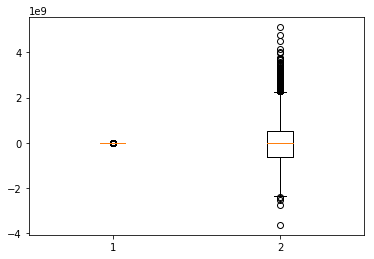

In [145]:
data = [ytrain, yhat_train]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

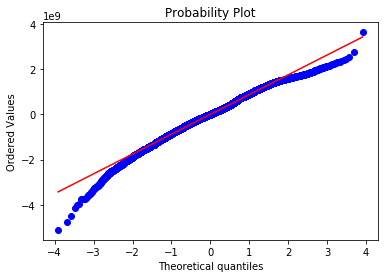

In [143]:
#Se realiza un grafico de probabilidado el cual nos entregara el mismo resultado que un QQplot ya que n es grande.
stats.probplot(e, dist="norm", plot=plt)
plt.show()

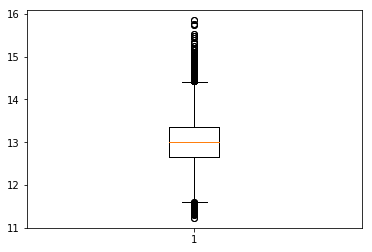

In [140]:
plt.boxplot(ytrain)
plt.show()

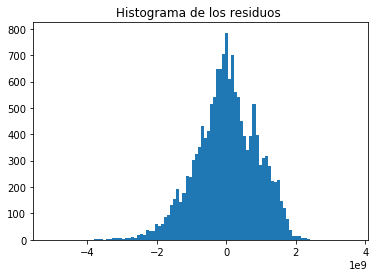

In [131]:
plt.title("Histograma de los residuos ")
plt.hist(e,bins=100)
plt.show()

## 1-h)

In [18]:
df_A = df.sample(3000)
frames = []
valor = np.log(df.price)
for z in np.arange(int(np.min(valor)),int(np.max(valor))+1,0.5):
    frames.append(df[(np.log(df.price) >= z) & (np.log(df.price) < z+0.5)].head(500))
df_B = pd.concat(frames).sample(3000)
X_A = df_A.iloc[:,1:].values
y_A = df_A.price
X_B = df_B.iloc[:,1:].values
y_B = df_B.price
from sklearn.model_selection import train_test_split
Xtrain_A, Xval_A, ytrain_A, yval_A = train_test_split(X_A, y_A, test_size=0.3, random_state=42)
Xtrain_B, Xval_B, ytrain_B, yval_B = train_test_split(X_B, y_B, test_size=0.3, random_state=42)

## 4. Peliculas

Tenemos 145256 características, debido a todas las combinaciones de palabras posibles de las críticas/reviews de cada película.

Son 1147 elementos de entrenamiento, 254 elementos de prueba, y 317 elementos para el cross-validation.


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csc_matrix
from scipy.io import mmread
#X_movies = pd.SparseDataFrame( csr_matrix(mmread('train.x.mm')) )
X_movies = csc_matrix(mmread('train.x.mm'))
y_movies = np.loadtxt('train.y.dat')
X_movies_test = csc_matrix(mmread('test.x.mm'))
y_movies_test = np.loadtxt('test.y.dat')

In [ ]:
import sklearn.linear_model as lm
model = lm.LinearRegression(fit_intercept = False)
model.fit(X_movies, y_movies)
print("Usando regresión lineal ordinaria, sin preprocesamiento, R^2 es: ", model.score(X_movies_test, y_movies_test))

Centering sparse data would destroy the sparseness structure in the data, and thus rarely is a sensible thing to do. However, it can make sense to scale sparse inputs, especially if features are on different scales.

MaxAbsScaler and maxabs_scale were specifically designed for scaling sparse data, and are the recommended way to go about this. However, scale and StandardScaler can accept scipy.sparse matrices as input, as long as with_mean=False is explicitly passed to the constructor. Otherwise a ValueError will be raised as silently centering would break the sparsity and would often crash the execution by allocating excessive amounts of memory unintentionally. RobustScaler cannot be fitted to sparse inputs, but you can use the transform method on sparse inputs.

Note that the scalers accept both Compressed Sparse Rows and Compressed Sparse Columns format (see scipy.sparse.csr_matrix and scipy.sparse.csc_matrix). Any other sparse input will be converted to the Compressed Sparse Rows representation. To avoid unnecessary memory copies, it is recommended to choose the CSR or CSC representation upstream.

Finally, if the centered data is expected to be small enough, explicitly converting the input to an array using the toarray method of sparse matrices is another option.

In [169]:
#Estandarizacion del dataset
from sklearn.preprocessing import MaxAbsScaler
scaler_movies = MaxAbsScaler().fit(X_movies) # Para matriz sparse
#X_scaled_movies_train = pd.DataFrame(scaler_movies.transform(X_movies), columns=X_movies.columns)
X_scaled_movies_train = scaler_movies.transform(X_movies)

# Se ingresa columna de unos, que son los pesos o coeficientes del primer parametro (el intercepto, beta_0)
#X_scaled_movies_train.insert(X_scaled_movies_train.shape[1], 'intercept', np.ones(X_scaled_movies_train.shape[0]))
from scipy.sparse import hstack
matriz_de_unos = csc_matrix(np.ones(X_scaled_movies_train.shape[0])[:, None])
print(matriz_de_unos.shape)
print(X_scaled_movies_train.shape)
X_scaled_movies_train = hstack((X_scaled_movies_train, matriz_de_unos))
print(X_scaled_movies_train.shape)

#df_scaled_train.info()
#X_scaled_movies_train.describe()


model_movies = lm.LinearRegression(fit_intercept = False)
model_movies.fit(X_scaled_movies_train, y_movies)


scaler_movies_test = MaxAbsScaler().fit(X_movies_test) # Para matriz sparse
X_scaled_movies_test = scaler_movies_test.transform(X_movies_test)
matriz_de_unos = csc_matrix(np.ones(X_scaled_movies_test.shape[0])[:, None])
X_scaled_movies_test = hstack((X_scaled_movies_test, matriz_de_unos))
print(model.score(X_scaled_movies_test, y_movies_test))

NameError: name 'X_movies' is not defined

In [170]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(model_movies, threshold=3.0)
selector.fit(X_scaled_movies_train, y_movies)

NameError: name 'model_movies' is not defined

In [171]:
selector.support_

NameError: name 'selector' is not defined

In [ ]:
n_features = selector.transform(X_scaled_movies_train)

In [ ]:
n_features

In [ ]:
model_movies = lm.LinearRegression(fit_intercept = False)
model_movies.fit(X_scaled_movies_train, y_movies)


scaler_movies_test = MaxAbsScaler().fit(X_movies_test) # Para matriz sparse
X_scaled_movies_test = scaler_movies_test.transform(X_movies_test)
matriz_de_unos = csc_matrix(np.ones(X_scaled_movies_test.shape[0])[:, None])
X_scaled_movies_test = hstack((X_scaled_movies_test, matriz_de_unos))
print(model.score(X_scaled_movies_test, y_movies_test))